# Final Projects

### **Team members:**
#### Mirco Lescart
#### Freddy Fernandes
#### Parsa Mastouri Kashani
#### Arina Sadeghi Khiabanian

# Libraries

In the first step of the project,we installed some libraries.

In [ ]:
# Installing the transformers library and additional libraries if looking process
!pip install -q transformers
!pip install mlcm

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import lr_scheduler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Settings

As mentioned in the project FAQ, we also implemented 5 different random seeds for our project.we tried seed number 42, 123, 456, 789, 1000.

In [ ]:
# Random seed to repeat experiments.
RANDOM_SEED = 123
transformers.set_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In this step,we defined the pre-trained model, maximum sequence lengths, batch sizes, epochs, learning rate, and tokenizer instantiation for tokenizing input data to establish the groundwork for efficient training and processing of textual inputs with the BERT-based model.

In [ ]:
#card_name = 'bert-base-uncased'
card_name = 'prajjwal1/bert-tiny'
MAX_LEN_EMO = 300
MAX_LEN_TRI = 512
BATCH_SIZE = 1
EMO_EPOCHS = 5
TRI_EPOCHS = 1
LEARNING_RATE = 2e-05
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
tokenizer = AutoTokenizer.from_pretrained(card_name)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


# Importing and Preprocessing the data

In this cell of code,we converted our JSON formatted file into a Pandas DataFrame, and then removed the 'episode' column to prepare the data for further processing or analysis.

In [ ]:
import pandas as pd
import json

# Specify the path to your JSON file
json_file_path = 'MELD_train_efr.json'  # Replace with your file path

# Open the file and load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Convert the JSON data to a Pandas DataFrame
df = pd.json_normalize(data)

# Now 'df' is a Pandas DataFrame containing the JSON data
df.drop('episode', axis=1, inplace=True)

As it was mentioned in the project FAQ, there are some NaN in the data set so we should replace them with 0.0 within lists.

In [ ]:
# Function to replace NaN with 0.0 in a list
def replace_nan_with_zero_list(lst):
    return [0.0 if pd.isna(x) else x for x in lst]

# Applying the function to the specified column
df['triggers'] = df['triggers'].apply(lambda x: replace_nan_with_zero_list(x))

# Convert each element in the lists to integers
df['triggers'] = df['triggers'].apply(lambda x: [int(i) for i in x])

df['triggers'].explode().unique()

array([0, 1], dtype=object)

Splitting the dataset into training, validation, and test sets using the train_test_split function from scikit-learn.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Split into training and temporary set (temp_set)
df_temp, df_test = train_test_split(df, test_size=0.1)

# Step 2: Split temp_set into training and validation sets
df_train, df_validation = train_test_split(df_temp, test_size=1/9)

In [ ]:
emotions = df['emotions'].explode().unique()

# Create a mapping from item to number
emotion_item_to_number = {item: number for number, item in enumerate(emotions)}

# Create a mapping from number to item
emotion_number_to_item = {number: item for number, item in enumerate(emotions)}

print(emotion_number_to_item)

emotion_number_to_one_hot = { 0: [1,0,0,0,0,0,0],
                              1: [0,1,0,0,0,0,0],
                              2: [0,0,1,0,0,0,0],
                              3: [0,0,0,1,0,0,0],
                              4: [0,0,0,0,1,0,0],
                              5: [0,0,0,0,0,1,0],
                              6: [0,0,0,0,0,0,1]}

one_hot_to_emotion_number = lambda one_hot : np.where(one_hot)[0]

{0: 'neutral', 1: 'surprise', 2: 'fear', 3: 'sadness', 4: 'joy', 5: 'disgust', 6: 'anger'}


### making data extenders for utterances, emotions and triggers

In [ ]:
def dataExtender_utt(df):
  rows = []
  for i1 in range(df.shape[0]):
    for i2, _ in enumerate(df.iloc[i1]['speakers']):
      new_row = pd.DataFrame({'speakers': [df.iloc[i1]['speakers'][i2]],
                          'utterances': [df.iloc[i1]['utterances'][i2]],
                          })
      rows.append(new_row)
  return pd.concat(rows, ignore_index=True).drop_duplicates()

In [ ]:
def dataExtender_emo(df):
    rows = []
    for i1 in range(df.shape[0]):
        for i2, _ in enumerate(df.iloc[i1]['speakers']):
            new_row = pd.DataFrame({'speakers': [df.iloc[i1]['speakers'][i2]],
                                    'emotions': [df.iloc[i1]['emotions'][i2]],
                                    'utterances': [df.iloc[i1]['utterances'][i2]],
                                    })
            rows.append(new_row)
    return pd.concat(rows, ignore_index=True).drop_duplicates()

In [ ]:
def dataExtender_tri(df):
  rows = []
  for i1 in range(df.shape[0]):
    for i2, _ in enumerate(df.iloc[i1]['speakers']):
      new_row = pd.DataFrame({'speakers': [df.iloc[i1]['speakers'][i2]],
                          'utterances': [df.iloc[i1]['utterances'][i2]],
                          'triggers': [df.iloc[i1]['triggers'][i2]]
                          })
      rows.append(new_row)
  return pd.concat(rows, ignore_index=True).drop_duplicates()

In [ ]:
def dataExtender_emo_tri(df):
  rows = []
  for i1 in range(df.shape[0]):
    for i2, _ in enumerate(df.iloc[i1]['speakers']):
      new_row = pd.DataFrame({'speakers': [df.iloc[i1]['speakers'][i2]],
                          'emotions': [df.iloc[i1]['emotions'][i2]],
                          'utterances': [df.iloc[i1]['utterances'][i2]],
                          'triggers': [df.iloc[i1]['triggers'][i2]]
                          })
      rows.append(new_row)
  return pd.concat(rows, ignore_index=True).drop_duplicates()

In [ ]:
df_train_utt = dataExtender_utt(df_train)

**We have to drop the duplicates before splitting the data. Otherwise, we drop the duplicates in each set, but we still have same rows between the different sets**

In [ ]:
df_emo = dataExtender_emo(df)

df_temp, df_test_emo = train_test_split(df_emo, test_size=0.1)
df_train_emo, df_validation_emo = train_test_split(df_temp, test_size=1/9)

In [ ]:
df_train_emo

,speakers,emotions,utterances
20749,Monica,disgust,It’s wrong.
25973,Mr. Treeger,anger,": Oh yeah, of course you don't!"
4276,Monica,neutral,Well so?
937,Chandler,joy,David is going to propose to Phoebe.
25181,Rachel,neutral,"Oh, she does want to."
...,...,...,...
10561,Ross,surprise,I just didn't see the fast song coming.
12718,Phoebe,neutral,...like a...
18879,Mrs. Geller,neutral,"Oh that's all right, I'm coming back later wit..."
30322,Chandler,neutral,"Okay. Okay. All right. Help! Am I a Mark, or a..."


In [ ]:
df_tri = dataExtender_tri(df)

df_temp, df_test_tri = train_test_split(df_tri, test_size=0.1)
df_train_tri, df_validation_tri = train_test_split(df_temp, test_size=1/9)

In [ ]:
df_emo_tri = dataExtender_emo_tri(df)

df_temp, df_test_emo_tri = train_test_split(df_emo_tri, test_size=0.1)
df_train_emo_tri, df_validation_emo_tri = train_test_split(df_temp, test_size=1/9)

This observation shows us that emotions are almost independent of the the conversation but triggers are highly dependent on it.

In [ ]:
len_utt = len(df_train_utt)
len_emo = len(df_train_emo)
len_tri = len(df_train_tri)
len_emo_tri = len(df_train_emo_tri)


print(f'Only utterance: {len(df_train_utt)}')
print(f'emotion + utterance: {len(df_train_emo)}')
print(f'trigger + utterance: {len(df_train_tri)}')
print(f'Emotion + trigger + utterance: {len(df_train_emo_tri)}')

Only utterance: 7783
emotion + utterance: 6664
trigger + utterance: 9288
Emotion + trigger + utterance: 9381


As it can be seen the percentage of emotions dependent on the context is less than 1%. Unlike triggers which almost have a 27% dependency on the context

In [ ]:
print(f'Percentage of emotions which were dependent on the context: {((len_emo-len_utt)/len_utt)*100}')
print(f'Percentage of triggers which were dependent on the context: {((len_tri-len_utt)/len_utt)*100}')

Percentage of emotions which were dependent on the context: -14.377489399974303
Percentage of triggers which were dependent on the context: 19.337016574585636


In [ ]:
import random

def set_color(number_of_colors):
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

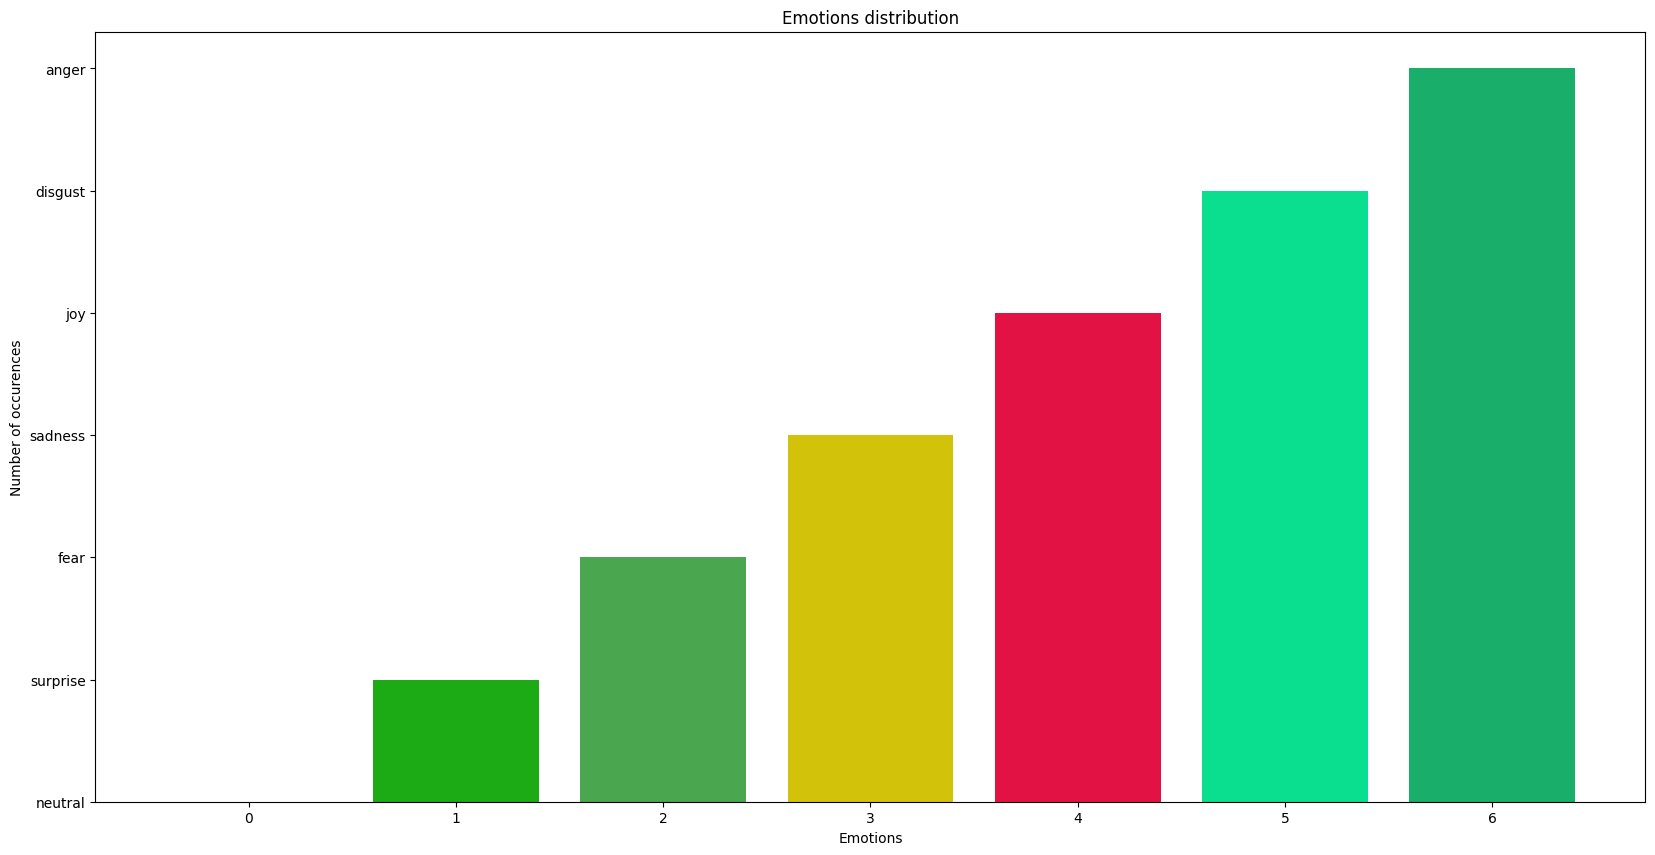

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(emotion_number_to_item.keys(), emotion_number_to_item.values(), color=set_color(len(emotion_number_to_item)))
plt.title("Emotions distribution")
plt.xlabel("Emotions")
plt.ylabel("Number of occurences")
plt.show()

# Descriptive analysis
## Emotions distribution

In this section we computed the occurrences and normalized frequencies of values in a given column. Then, we utilized our function to obtain the occurrences and normalized frequencies of emotions in the training, validation, and test sets, preparing the data for visualization or further analysis.

In [ ]:
# Get occurrences for a given column
def get_freq_col(data, column):
    all_values = []

    for dialog in range(data.shape[0]):
        for value in data.iloc[dialog][column]:
            all_values.append(value)

    unique, freq = np.unique(all_values, return_counts=True)
    freq = freq/np.sum(freq)

    return unique, freq

emotions_train, freq_train =  np.unique(df_train_emo.emotions, return_counts=1)
emotions_validation, freq_validation =  np.unique(df_validation_emo.emotions, return_counts=1)
emotions_test, freq_test =  np.unique(df_test_emo.emotions, return_counts=1)

# Normalize to help the visualization
freq_train = freq_train/sum(freq_train)
freq_validation = freq_validation/sum(freq_validation)
freq_test = freq_test/sum(freq_test)


Here, we have a bar chart showing the frequency distribution of emotions across the training, validation, and test datasets

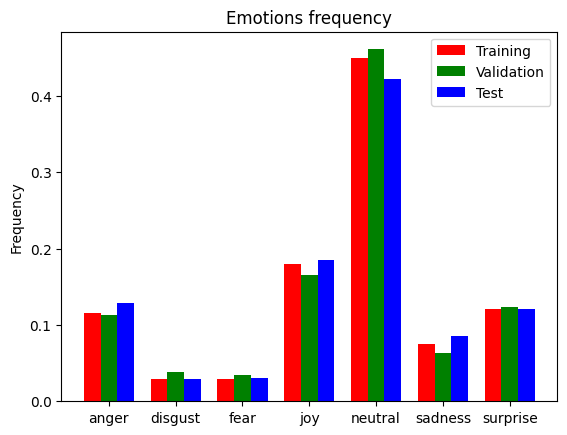

In [ ]:
N = len(emotions_train)
ind = np.arange(N)
width = 0.25

bar1 = plt.bar(ind, freq_train, width, color = 'r')
bar2 = plt.bar(ind+width, freq_validation, width, color='g')
bar3 = plt.bar(ind+width*2, freq_test, width, color = 'b')

plt.xlabel("")
plt.ylabel('Frequency')
plt.title("Emotions frequency")

plt.xticks(ind+width, emotions_train)
plt.legend( (bar1, bar2, bar3), ('Training', 'Validation', 'Test') )
plt.show()

We can see that the different sets have same emotion's distribution. Moreover, the neutral emotion is clearly predominant and the digust and fear emotions are less present in our data.

## Triggers distribution

### Proportion of zeros in each set

In [ ]:
triggers_train, freq_train =  get_freq_col(df_train, "triggers")
triggers_validation, freq_validation =  get_freq_col(df_validation, "triggers")
triggers_test, freq_test =  get_freq_col(df_test, "triggers")

print("Proportion of triggers equal to zeros:")
print(f"--> Training {freq_train[0]:.3}")
print(f"--> Validation {freq_validation[0]:.3}")
print(f"--> Test {freq_test[0]:.3}")

Proportion of triggers equal to zeros:
--> Training 0.838
--> Validation 0.846
--> Test 0.854


The different seems to have the same triggers distribution. We can also observe that most of the utterances are not triggers (+- 85%)

### Distance between the target and the triggers
Let's look at the distance between the utterances that caused the emotions flip and the target utterance, which is the last utterance.

For example, a distance of 1 means that the before last utterance , is a trigger for the emotion flip, i.e. the before last utterance cause the emotion flip. A distance of 0 means that the last utterance cause the emotion flip

In [ ]:
all_distances = []

for dialog in range(df.shape[0]):
    all_trig = df.iloc[dialog]["triggers"]
    active_trig = np.where(all_trig)[0]
    for trig in active_trig:
        dist = (len(all_trig)-1) - trig
        all_distances.append(dist)

trig, counts = np.unique(all_distances, return_counts=True)


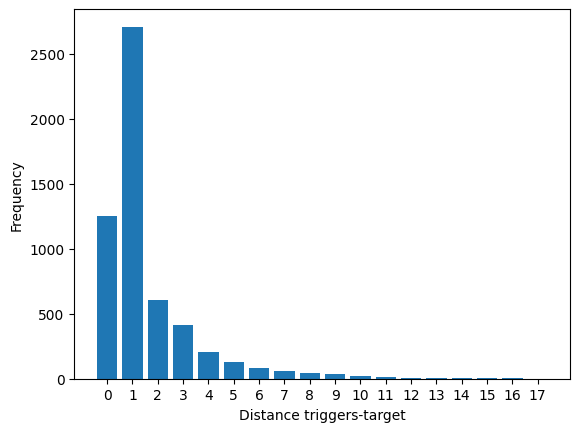

In [ ]:
#Plotting distance of triggers to target
plt.bar(trig, counts)
plt.xticks(trig, trig)
plt.xlabel("Distance triggers-target")
plt.ylabel("Frequency")
plt.show()

## Length utterances and dialog

In this section,we compute and visualize the distribution of dialog and utterance lengths, providing insights into the data's structure and potential characteristics

In [ ]:
utterances_length = []
dialog_length = np.zeros(df.shape[0])

for dialog in range(df.shape[0]):
    for utterance in df.iloc[dialog]["utterances"]:
        text_token = tokenizer.encode_plus(
                    utterance,
                    None,
                    add_special_tokens=True,
                    truncation=True,
                    padding='max_length',
                    return_token_type_ids=True
                )
        length = len(text_token['input_ids'])

        utterances_length.append(length)
        dialog_length[dialog] += length

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


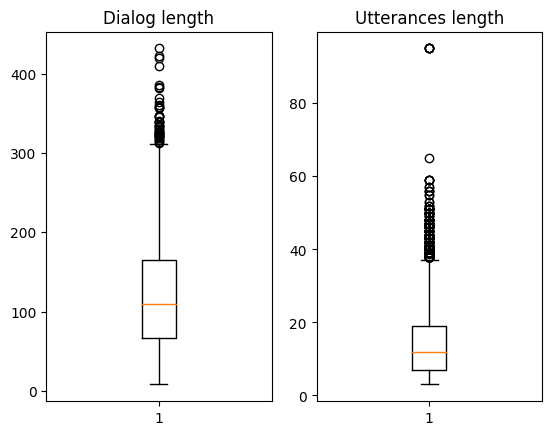

In [ ]:
#plotting dialog length and utterance length plots
ax, fig = plt.subplots(1,2)

plt.subplot(1,2,1)
plt.boxplot(dialog_length)
plt.title("Dialog length")

plt.subplot(1,2,2)
plt.boxplot(utterances_length)
plt.title("Utterances length")
plt.show()

# Baseline Model
## Uniform classifier

here,we defined a function that generates random predictions based on the unique values observed in a specified column of a DataFrame. It iterates through each dialog in the test data, collects the true values from the specified column, identifies unique values, and then randomly selects values from these unique values to create predictions. Then it applies this function to two columns, "emotions" and "triggers", in the test data. It computes and prints classification reports for the "emotions" column and computes the accuracy and F1-score for the "triggers" column, providing insights into the performance of a baseline model that randomly predicts from observed values in these columns.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def uniform_predict(column):
    true_values= []

    for dialog in range(df_test.shape[0]):
        for value in df_test.iloc[dialog][column]:
            true_values.append(value)

    # Get the different possible values
    diff_values = np.unique(true_values)

    # Draw uniformly one value among all the possible values.
    pred = np.random.choice(diff_values, len(true_values))

    return true_values, pred

In [ ]:
# Emotions: Uniform Classifier Evaluation
emotions_true, emotions_pred = uniform_predict("emotions")
print(f"Emotions: Uniform Classifier")
print(classification_report(emotions_true, emotions_pred,
                            #target_names = labels,
                            zero_division=1))

Emotions: Uniform Classifier
              precision    recall  f1-score   support

       anger       0.10      0.13      0.11       379
     disgust       0.04      0.19      0.06       103
        fear       0.04      0.18      0.06       106
         joy       0.19      0.14      0.16       712
     neutral       0.39      0.13      0.19      1544
     sadness       0.08      0.14      0.10       291
    surprise       0.11      0.12      0.12       472

    accuracy                           0.14      3607
   macro avg       0.14      0.15      0.12      3607
weighted avg       0.24      0.14      0.15      3607



In [ ]:
# Triggers: Uniform Classifier Evaluation
triggers_true, triggers_pred_uniform = uniform_predict("triggers")
print("Triggers:  Uniform Classifier")
print(classification_report(triggers_true, triggers_pred_uniform, zero_division=0))

print(f"--> Accuracy = {accuracy_score(triggers_true, triggers_pred_uniform):.3} \n"
      f"--> F1-score = {f1_score(triggers_true, triggers_pred_uniform, average='macro'):.3}")

Triggers:  Uniform Classifier
              precision    recall  f1-score   support

           0       0.85      0.50      0.63      3079
           1       0.14      0.49      0.22       528

    accuracy                           0.50      3607
   macro avg       0.50      0.49      0.42      3607
weighted avg       0.75      0.50      0.57      3607

--> Accuracy = 0.496 
--> F1-score = 0.424


## Most-frequent classifier

On the other hand,we defined a function(majority_predict) that predicts the most frequent category in a specified column of a DataFrame. It iterates through each dialog in the test data, collects the true values from the specified column, identifies the unique values and their frequencies from the training data, and then predicts the most frequent value for all instances in the test data.Then it applies this function to two columns, "emotions" and "triggers", in the test data. It computes and prints classification reports for the "emotions" column and computes the accuracy and F1-score for the "triggers" column, providing insights into the performance of a baseline model that predicts the most frequent category in these columns.

In [ ]:
# Predict the most frequent category
def majority_predict(column):
    true_values= []

    for dialog in range(df_test.shape[0]):
        for value in df_test.iloc[dialog][column]:
            true_values.append(value)

    # Get the different possible values and the frequency
    diff_values, frequency = get_freq_col(df_train, column)

    # Always predict the most frequent values
    pred = [diff_values[np.argmax(frequency)]] * len(true_values)

    return true_values, pred

In [ ]:
# Emotions: Majority Classifier Evaluation
emotions_true, emotions_pred = majority_predict("emotions")
print(f"Emotions : Majority Classifier ")
print(classification_report(emotions_true, emotions_pred,
                            #target_names = labels,
                            zero_division=1))

Emotions : Majority Classifier 
              precision    recall  f1-score   support

       anger       1.00      0.00      0.00       379
     disgust       1.00      0.00      0.00       103
        fear       1.00      0.00      0.00       106
         joy       1.00      0.00      0.00       712
     neutral       0.43      1.00      0.60      1544
     sadness       1.00      0.00      0.00       291
    surprise       1.00      0.00      0.00       472

    accuracy                           0.43      3607
   macro avg       0.92      0.14      0.09      3607
weighted avg       0.76      0.43      0.26      3607



In [ ]:
# Triggers: Majority Classifier Evaluation
triggers_true, triggers_pred_majority = majority_predict("triggers")
print("\nTriggers: Majority Classifier")
print(classification_report(triggers_true, triggers_pred_majority, zero_division=0))

print(f"Triggers : \n "
      f"--> Accuracy = {accuracy_score(triggers_true, triggers_pred_majority):.3} \n "
      f"--> F1-score = {f1_score(triggers_true, triggers_pred_majority, average='macro'):.3}")


Triggers: Majority Classifier
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3079
           1       0.00      0.00      0.00       528

    accuracy                           0.85      3607
   macro avg       0.43      0.50      0.46      3607
weighted avg       0.73      0.85      0.79      3607

Triggers : 
 --> Accuracy = 0.854 
 --> F1-score = 0.461


# Emotion Model


In our emotion model, we have implemented a specialized BERT model designed to discern the emotion within a single utterance, independent of its surrounding context or adjacent utterances. This decision stemmed from our observation that within the provided dataset, utterances exhibited minimal dependency on contextual information from surrounding utterances. Consequently, our model focuses exclusively on the content and structure of individual utterances to predict the corresponding emotions expressed within them. This approach reflects our adaptation to the characteristics of the dataset and aims to optimize the model's performance by concentrating on the intrinsic features of each utterance in isolation.

In [ ]:
class EmotionDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, emotion_item_to_number, emotion_number_to_one_hot):
        # Initialize the dataset with necessary parameters and data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotion_item_to_number = emotion_item_to_number
        self.emotion_number_to_one_hot = emotion_number_to_one_hot

        self.data = dataframe
        self.speakers = dataframe.speakers
        self.utterances = dataframe.utterances
        self.emotions = dataframe.emotions

    def __len__(self):
        # Define the length of the dataset (number of data samples)
        return len(self.data)

    def __getitem__(self, index):
        # Get a specific data sample at the given index
        row = self.data.iloc[index]
        speakers = row['speakers']
        utterance = row['utterances']
        emotion = row['emotions']
        target = self.emotion_number_to_one_hot[self.emotion_item_to_number[emotion]]

        # Tokenize and preprocess the input data using the tokenizer
        inputs = self.tokenizer.encode_plus(
            utterance,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        # Return the preprocessed data as tensors
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.float),
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

print("Train Dataset: {}".format(df_train_emo.shape))
print("Validation Dataset: {}".format(df_validation_emo.shape))
print("Test Dataset: {}".format(df_test_emo.shape))

# Creating datasets for training, validation, and testing using the EmotionDataset class
emo_training_set = EmotionDataset(df_train_emo, tokenizer, MAX_LEN_EMO, emotion_item_to_number, emotion_number_to_one_hot)
emo_validation_set = EmotionDataset(df_validation_emo, tokenizer, MAX_LEN_EMO, emotion_item_to_number, emotion_number_to_one_hot)
emo_testing_set = EmotionDataset(df_test_emo, tokenizer, MAX_LEN_EMO, emotion_item_to_number, emotion_number_to_one_hot)

Train Dataset: (6664, 3)
Validation Dataset: (833, 3)
Test Dataset: (834, 3)


In [ ]:
# Define parameters for dataloaders
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
validation_params = {'batch_size': VALID_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': 0
                    }
test_params = {'batch_size': VALID_BATCH_SIZE,
               'shuffle': True,
               'num_workers': 0
              }

# Creating dataloaders for training, validation, and testing
training_loader = DataLoader(emo_training_set, **train_params)
validation_loader = DataLoader(emo_validation_set, **validation_params)
testing_loader = DataLoader(emo_testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
import torch.nn.functional as F

class BERTClass(torch.nn.Module):
    def __init__(self, card_name):
        super(BERTClass, self).__init__()
        self.transformer = AutoModel.from_pretrained(card_name, return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        if card_name == 'bert-base-uncased' :
            self.dense1 = torch.nn.Linear(768, 384)
        elif card_name == 'prajjwal1/bert-tiny' :
            self.dense1 = torch.nn.Linear(128, 384)
        self.dense2 = torch.nn.Linear(384, 192)
        self.dense3 = torch.nn.Linear(192, 7)

    def forward(self, ids, mask, token_type_ids):
        _, output = self.transformer(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.dropout(output)
        output = self.dense1(output)
        output = F.relu(output)
        output = self.dense2(output)
        output = F.relu(output)
        output = self.dense3(output)
        return output

In [ ]:
# Training function for the model
def train(model, dataloader, optimizer,
          #scheduler,
          LEARNING_RATE, EPOCHS, epoch, criterion):
    size = len(dataloader.dataset)
    total_items = len(dataloader)
    model.train()

    for batch, data in tqdm(enumerate(dataloader, 0), total=total_items):
        # Get data from the dataloader
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(ids, mask, token_type_ids)

        # Calculate loss and backpropagate
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        #Print loss and progress
        #if batch % 5000 == 0:
        #    print(f'Epoch: {epoch}, Loss: {loss.item()}')

        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(ids)
        #    print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    #scheduler.step()

In [ ]:
# Validation function for the model
def validation(epoch, model, dataloader, criterion, frozen=False):
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader, 0):
            # Get data from the dataloader
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            # Forward pass through the model
            outputs = model(ids, mask, token_type_ids)

            # Calculate validation loss
            val_loss += criterion(outputs, targets).item()

        val_loss /= num_batches
        print(val_loss)

        # Check if validation loss improved and save the model
        # if val_loss <= val_loss_min_input:
        #     if epoch > 0:
        #         print('Validation loss decreased ({:.8f} --> {:.8f}). Saving model ...'.format(val_loss_min_input, val_loss))
        #     else:
        #         print('Saving model ...')
            # Save the best model
        torch.save(model.state_dict(), f"emo_model_{'Frozen' if frozen else 'Full'}_{epoch+1}.pth")
        print("Saved PyTorch Model State to model.pth\n")
        #val_loss_min_input = val_loss
        # else:
        #     print('Validation loss didn\'t go down -____-')

    #return val_loss_min_input
    return val_loss

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights for the training data
y_train = []
for index, row in df_train_emo.iterrows():
    for i in range(len(row["utterances"])):
        y_train.append(row["emotions"])
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights}")

# Convert class weights to PyTorch tensor
emotion_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss criterion using CrossEntropyLoss with class weights
criterion = torch.nn.CrossEntropyLoss(
    #weight=emotion_weights
)

Class weights: [1.0782368  3.85816045 4.59323512 0.81987954 0.32114482 1.59988072
 1.56971179]


In [ ]:
# Define a testing function for the model
def test(model, dataLoader):
    model.eval()
    fin_emotion_targets=[]
    fin_emotion_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(dataLoader, 0):
            # Get data from the dataloader
            length = len(data["ids"])
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            # Forward pass through the model
            outputs = model(ids, mask, token_type_ids)
            fin_emotion_targets.extend(targets.cpu().detach().numpy().tolist())

            # Convert model outputs to one-hot encoded predictions
            fin_emotion_outputs.extend([[1 if i == torch.argmax(outputs, dim=1).cpu().detach().numpy()[d] else 0 for i in range(7)] for d in range(length)])
    return fin_emotion_outputs, fin_emotion_targets

### Freezed Model

We are supposed to implement our model in two different ways.First we implemented it with freezed model and then we implemented the full model.

In [ ]:
emo_model_frozen = BERTClass(card_name)
emo_model_frozen.to(device)

BERTClass(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
# Freeze the BERT weigths
for param in emo_model_frozen.transformer.parameters():
    param.requires_grad = False

In [ ]:
# Calculate the total number of training steps
total_steps = len(training_loader) * EMO_EPOCHS

# Define the optimizer (AdamW) and learning rate scheduler
optimizer = torch.optim.AdamW(params=emo_model_frozen.parameters(), lr=LEARNING_RATE)
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

In [ ]:
# Initialize a list to store validation loss during training with frozen layers
freezed_emo_val_loss = []

# Initialize a variable to track the minimum validation loss
val_loss_min = np.Inf

# Training loop for the model with frozen layers
for epoch in range(EMO_EPOCHS):
  print(f"Epoch no {epoch+1}/{EMO_EPOCHS}")
  train(emo_model_frozen,
        training_loader,
        optimizer,
        #scheduler,
        LEARNING_RATE,
        EMO_EPOCHS,
        epoch,
        criterion)

  # Update the minimum validation loss
  val_loss_min = validation(epoch,
                            #val_loss_min,
                            emo_model_frozen,
                            validation_loader,
                            criterion,
                            frozen=True
                            )

  # Append the current minimum validation loss to the list
  freezed_emo_val_loss.append(val_loss_min)

Epoch no 1/5


100%|██████████| 6664/6664 [02:27<00:00, 45.18it/s]


1.53062536457435
Saved PyTorch Model State to model.pth

Epoch no 2/5


100%|██████████| 6664/6664 [02:33<00:00, 43.35it/s]


1.4608423176611744
Saved PyTorch Model State to model.pth

Epoch no 3/5


100%|██████████| 6664/6664 [02:33<00:00, 43.37it/s]


1.4263018334255355
Saved PyTorch Model State to model.pth

Epoch no 4/5


100%|██████████| 6664/6664 [02:33<00:00, 43.40it/s]


1.3925213026327818
Saved PyTorch Model State to model.pth

Epoch no 5/5


100%|██████████| 6664/6664 [02:33<00:00, 43.47it/s]


1.3707811727064425
Saved PyTorch Model State to model.pth



In [ ]:
# Test the trained model and calculate emotion outputs and targets
emotion_outputs, emotion_targets = test(emo_model_frozen, testing_loader)

In [ ]:
# Print a classification report based on the emotion outputs and targets
print(classification_report(emotion_targets, emotion_outputs,
                            #target_names = labels,
                            zero_division=1))

              precision    recall  f1-score   support

           0       0.51      0.95      0.66       352
           1       0.40      0.32      0.35       101
           2       1.00      0.00      0.00        25
           3       1.00      0.00      0.00        71
           4       0.31      0.17      0.22       154
           5       1.00      0.00      0.00        24
           6       0.56      0.08      0.15       107

   micro avg       0.48      0.48      0.48       834
   macro avg       0.68      0.22      0.20       834
weighted avg       0.54      0.48      0.38       834
 samples avg       0.48      0.48      0.48       834



### Full Model

In [ ]:
# Initialize a new instance of the model without frozen layers
emo_model_full = BERTClass(card_name)
emo_model_full.to(device)

BERTClass(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
# Create a new optimizer and scheduler
LEARNING_RATE = 1e-05
optimizer = torch.optim.AdamW(params=emo_model_full.parameters(), lr=LEARNING_RATE)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
# Initialize a list to store validation loss during training without frozen layers
emo_val_loss = []
EMO_EPOCHS = 1

# Training loop for the model without frozen layers
for epoch in range(EMO_EPOCHS):
    print(f"Epoch no {epoch+1}/{EMO_EPOCHS}")
    train(emo_model_full,
          training_loader,
          optimizer,
          #scheduler,
          LEARNING_RATE,
          EMO_EPOCHS,
          epoch,
          criterion)

    # Update the minimum validation loss
    val_loss = validation(epoch,
                          emo_model_full,
                          validation_loader,
                          criterion)

    # Append the current minimum validation loss to the list
    emo_val_loss.append(val_loss)

Epoch no 1/5


100%|██████████| 6664/6664 [10:21<00:00, 10.72it/s]


1.3067054063627341
Saved PyTorch Model State to model.pth

Epoch no 2/5


100%|██████████| 6664/6664 [10:20<00:00, 10.74it/s]


1.3824920302071348
Saved PyTorch Model State to model.pth

Epoch no 3/5


100%|██████████| 6664/6664 [10:20<00:00, 10.75it/s]


1.55822868267631
Saved PyTorch Model State to model.pth

Epoch no 4/5


100%|██████████| 6664/6664 [10:21<00:00, 10.73it/s]


1.7538576781289095
Saved PyTorch Model State to model.pth

Epoch no 5/5


100%|██████████| 6664/6664 [10:19<00:00, 10.75it/s]


1.84053249087292
Saved PyTorch Model State to model.pth



In [ ]:
# emo_model_full.load_state_dict(torch.load('emo_model_Full_10.pth'))
# emo_model_full = emo_model_full.to(device)

# Test the trained model and calculate emotion outputs and targets
emotion_outputs, emotion_targets = test(emo_model_full, testing_loader)
# Print a classification report based on the emotion outputs and targets
print(classification_report(emotion_targets, emotion_outputs,
                            #target_names = labels,
                            zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       352
           1       0.52      0.53      0.53       101
           2       1.00      0.00      0.00        25
           3       0.50      0.14      0.22        71
           4       0.51      0.56      0.53       154
           5       1.00      0.00      0.00        24
           6       0.54      0.35      0.42       107

   micro avg       0.59      0.59      0.59       834
   macro avg       0.67      0.35      0.35       834
weighted avg       0.60      0.59      0.55       834
 samples avg       0.59      0.59      0.59       834



In [ ]:
def sequence_test(model, dataLoader):
    model.eval()
    fin_emotion_targets=[]
    fin_emotion_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(dataLoader, 0):
            # Get data from the dataloader
            length = len(data["ids"])
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            one_sequence_fin_emotion_targets = []
            one_sequence_fin_emotion_outputs = []
            for i in range(length):
              # Forward pass through the model
              outputs = model(ids, mask, token_type_ids)
              one_sequence_fin_emotion_targets.extend(targets.cpu().detach().numpy().tolist())

              # Convert model outputs to one-hot encoded predictions
              one_sequence_fin_emotion_outputs.extend([[1 if i == torch.argmax(outputs, dim=1).cpu().detach().numpy()[d] else 0 for i in range(7)] for d in range(length)])

            fin_emotion_targets.extend(one_sequence_fin_emotion_targets)
            fin_emotion_outputs.extend(one_sequence_fin_emotion_outputs)

    return fin_emotion_outputs, fin_emotion_targets

In [ ]:
# Test the trained model and calculate emotion outputs and targets
emotion_outputs, emotion_targets = test(emo_model_full, testing_loader)

In [ ]:
# Print a classification report based on the emotion outputs and targets
print(classification_report(emotion_targets, emotion_outputs,
                            #target_names = labels,
                            zero_division=1))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       394
           1       0.30      0.77      0.43        97
           2       0.12      0.18      0.14        17
           3       1.00      0.00      0.00        55
           4       0.86      0.16      0.28       146
           5       1.00      0.00      0.00        27
           6       0.36      0.33      0.34        98

   micro avg       0.55      0.55      0.55       834
   macro avg       0.62      0.32      0.28       834
weighted avg       0.68      0.55      0.51       834
 samples avg       0.55      0.55      0.55       834



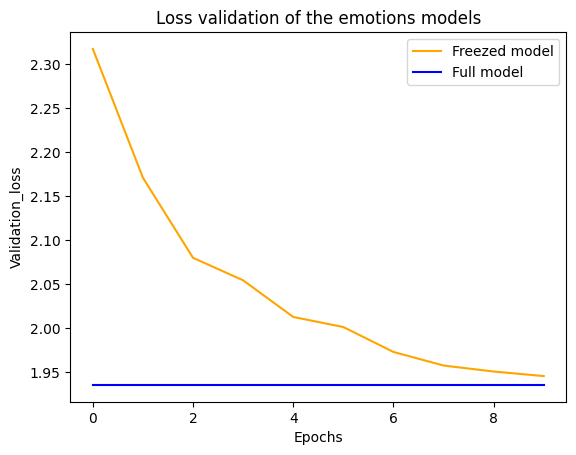

In [ ]:
# Plot validation loss for both the frozen and full models
plt.plot(freezed_emo_val_loss, color="orange", label="Freezed model")
plt.plot(emo_val_loss, color="b", label="Full model")
plt.ylabel("Validation_loss")
plt.xlabel("Epochs")
plt.title("Loss validation of the emotions models")
plt.legend()
plt.show()

### Testing the f1 metric functions:

In [ ]:
# Define a function to compute the unrolled sequence F1 score
def compute_unrolled_sequence_f1(true_labels, pred_labels):
    # Concatenate true and predicted labels to calculate F1 score
    unrolled_true = np.concatenate([np.array(dialogue) for dialogue in true_labels])
    unrolled_pred = np.concatenate([np.array(dialogue) for dialogue in pred_labels])
    return f1_score(unrolled_true, unrolled_pred, average='macro')

# Define a function to compute the sequence F1 score
def compute_sequence_f1(true_labels, pred_labels):
    # Calculate F1 scores for individual dialogues and average them
    f1_scores = []
    for dialogue_true, dialogue_pred in zip(true_labels, pred_labels):
        f1 = f1_score(dialogue_true, dialogue_pred, average='macro')
        f1_scores.append(f1)
    return np.mean(f1_scores)

# Compute sequence F1 and unrolled sequence F1 scores
sequence_f1 = compute_sequence_f1(emotion_targets, emotion_outputs)
unrolled_sequence_f1 = compute_unrolled_sequence_f1(emotion_targets, emotion_outputs)

# Print the computed F1 scores
print(f"Sequence F1 Score: {sequence_f1}")
print(f"Unrolled Sequence F1 Score: {unrolled_sequence_f1}")

Sequence F1 Score: 0.4838129496402878
Unrolled Sequence F1 Score: 0.48381294964028776


# Trigger Model


In this phase, we have developed a dedicated BERT model tailored specifically for identifying triggers within conversations. Unlike the emotion recognition task where the context of surrounding utterances is disregarded, trigger detection requires a broader understanding of the conversation flow. To achieve this, we employ a process that involves concatenating the emotions derived from our specialized emotion BERT model with the entirety of the conversation.

The key distinction lies in our approach to trigger detection, wherein we capitalize on the cumulative emotional context of the conversation. We concatenate the identified emotions with the complete conversation and iteratively evaluate each utterance within the context of the entire dialogue. This iterative process involves looping through the conversation as many times as there are utterances, augmenting the text with the previously identified emotional triggers.

By amalgamating the emotional cues with the conversation's text iteratively, our model gains a more comprehensive understanding of the emotional dynamics at play within the dialogue. This method enables the model to discern whether each utterance serves as a trigger, thereby enhancing the accuracy and robustness of our trigger detection mechanism.

In [ ]:
# Function to expand the dataframe by splitting multi-speaker dialogues
def dataExtender(df):
  rows = []
  for i1 in range(df.shape[0]):
    for i2, _ in enumerate(df.iloc[i1]['speakers']):
      new_row = pd.DataFrame({'speakers': [df.iloc[i1]['speakers']],
                          'emotions': [df.iloc[i1]['emotions']],
                          'utterances': [df.iloc[i1]['utterances']],
                          'triggers': [df.iloc[i1]['triggers'][:i2+1]],
                          'id': i1})
      rows.append(new_row)
  return pd.concat(rows, ignore_index=True)

In [ ]:
# Expand the training, validation, and test dataframes
tri_df_train = dataExtender(df_train)
tri_df_validation = dataExtender(df_validation)
tri_df_test = dataExtender(df_test)

In [ ]:
# Define the TriggerDataset class for the expanded data
class TriggerDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, emotion_item_to_number, emotion_number_to_one_hot):
        # Initialize the dataset with necessary parameters and data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotion_item_to_number = emotion_item_to_number
        self.emotion_number_to_one_hot = emotion_number_to_one_hot

        self.data = dataframe
        self.speakers = dataframe.speakers
        self.utterances = dataframe.utterances
        self.emotions = dataframe.emotions
        self.triggers = dataframe.triggers

    def __len__(self):
        # Define the length of the dataset (number of data samples)
        return len(self.data)

    def __getitem__(self, index):
        # Get a specific data sample at the given index
        row = self.data.iloc[index]
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']
        target = triggers[-1]

        # # Construct the text input by concatenating speakers, utterances, emotions, and triggers
        # text = ''
        # for i, d in enumerate(speakers):
        #     text = text + f"[{d}]:{utterances[i]}"

        # text = text + ' emotions: '

        # for i in range(len(emotions)):
        #     text = text + f'{emotions[i]},'

        # text = text + ' triggers: '

        # for i in range(len(triggers)-1):
        #     text = text + f'{triggers[i]} '

        text = ''
        for i, d in enumerate(speakers):
            text = text + f"[{d}]:{utterances[i]} {'TRIGGER' if i == len(triggers)-1 else ''} "
            #text = text + f"[{d}]:{utterances[i]} {#emotions[i]} {'TRIGGER' if i == len(triggers)-1 else ''} "

        # print(len(speakers))
        # print(triggers)
        # print(text)

        # Tokenize and preprocess the input data using the tokenizer
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.float),
            #'id': torch.tensor(id, dtype=torch.long)
        }

In [ ]:
# Create datasets and data loaders for the trigger classification task
tri_training_set = TriggerDataset(tri_df_train, tokenizer, MAX_LEN_TRI, emotion_item_to_number, emotion_number_to_one_hot)
tri_validation_set = TriggerDataset(tri_df_validation, tokenizer, MAX_LEN_TRI, emotion_item_to_number, emotion_number_to_one_hot)
tri_testing_set = TriggerDataset(tri_df_test, tokenizer, MAX_LEN_TRI, emotion_item_to_number, emotion_number_to_one_hot)

In [ ]:
# Define parameters for data loaders
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

# Create data loaders for training, validation, and testing
tri_training_loader = DataLoader(tri_training_set, **train_params)
tri_validation_loader = DataLoader(tri_validation_set, **validation_params)
tri_testing_loader = DataLoader(tri_testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
import torch.nn.functional as F

# Define the BERT-based model for trigger classification
class BERTClass(torch.nn.Module):
    def __init__(self, card_name):
        super(BERTClass, self).__init__()
        self.transformer = AutoModel.from_pretrained(card_name, return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        if card_name == 'bert-base-uncased' :
            self.dense1 = torch.nn.Linear(768, 384)
        elif card_name == 'prajjwal1/bert-tiny' :
            self.dense1 = torch.nn.Linear(128, 384)
        self.dense2 = torch.nn.Linear(384, 192)
        self.dense3 = torch.nn.Linear(192, 1)

    def forward(self, ids, mask, token_type_ids):
        _, output = self.transformer(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.dropout(output)
        output = self.dense1(output)
        output = F.relu(output)
        output = self.dense2(output)
        output = F.relu(output)
        output = self.dense3(output)
        return output


In [ ]:
# Training function for the trigger classification model
def train(model, dataloader, optimizer,
          #scheduler,
          LEARNING_RATE, EPOCHS, epoch, criterion):
    size = len(dataloader.dataset)
    total_items = len(dataloader)
    model.train()

    for batch, data in tqdm(enumerate(dataloader, 0), total=total_items):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        # Zero out gradients
        optimizer.zero_grad()

        outputs = model(ids, mask, token_type_ids)

        # Compute the loss and backpropagate
        loss = criterion(outputs.squeeze(dim=1), targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # if batch % 5000 == 0:
        #     print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        #     print()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(ids)
        #     print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Validation function for trigger classification
def validation(epoch, val_loss_min_input, model, dataloader, criterion, frozen=False):
    # Calculate validation loss and check for improvement
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader, 0):
            # Extract data from the dataloader
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += criterion(outputs.squeeze(dim=1), targets).item()

        val_loss /= num_batches
        print(val_loss)
        print(f"\nValidation loss: {val_loss:>8f}.")

        # Save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            if epoch > 0:
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else:
                print('Saving model ...')
            # Save the best model
            torch.save(model.state_dict(), f"tri_model_{'Frozen' if frozen else 'Full'}_{epoch+1}.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
        else:
            print('Validation loss didn\'t go down -____-')

    return val_loss_min_input

In [ ]:
tri_df_train['last_item'] = tri_df_train['triggers'].apply(lambda x: x[-1])

# Calculate class weights for trigger classification
y_train_trigger_tensor = torch.LongTensor(tri_df_train['last_item'].values)
unique_triggers = torch.unique(y_train_trigger_tensor).numpy()
trigger_weights = compute_class_weight('balanced', classes=unique_triggers, y=y_train_trigger_tensor.numpy())
trigger_weights = torch.FloatTensor(trigger_weights).detach().to(device)

# Define the criterion for trigger classification
criterion = torch.nn.BCEWithLogitsLoss(
    #pos_weight=(trigger_weights[1]/trigger_weights[0]).detach()
    )

In [ ]:
# Function to get the threshold for trigger classification
def get_threshold(tri_model, dataLoader):
    # Evaluate different thresholds and choose the one with the highest F1 score
    tri_model.eval()
    fin_trigger_targets=[]
    fin_trigger_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(dataLoader, 0):
            length = len(data)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = tri_model(ids, mask, token_type_ids)
            fin_trigger_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_trigger_outputs.extend(torch.sigmoid(outputs.squeeze(dim=1)).cpu().detach().numpy().tolist())

    results = {}
    for tr in np.arange(0.1, 0.9, 0.01):
        tr = round(tr, 2)
        predictions= np.array(fin_trigger_outputs) >= tr
        results[tr] = f1_score(fin_trigger_targets, predictions, average='macro')
    return max(results,key=results.get)

In [ ]:
# Function to test the trigger classification model
def test(model, dataLoader, threshold):
    # Evaluate the model on the test data using the selected threshold
    model.eval()
    fin_trigger_targets=[]
    fin_trigger_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(dataLoader, 0):
            length = len(data["ids"])
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_trigger_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_trigger_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return np.array(fin_trigger_outputs >= threshold).astype(int).tolist(), fin_trigger_targets

### Freezed Model

In [ ]:
# Initialize the trigger classification model and move it to the device
tri_model_frozen = BERTClass(card_name)
tri_model_frozen.to(device)

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

BERTClass(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [ ]:
# Freeze the BERT weigths
for param in tri_model_frozen.transformer.parameters():
    param.requires_grad = False

In [ ]:
# Define training parameters and create optimizer and scheduler
total_steps = len(tri_training_loader)*TRI_EPOCHS

optimizer = torch.optim.AdamW(params=tri_model_frozen.parameters(), lr=LEARNING_RATE)
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

In [ ]:
# Initialize variables for tracking validation loss and results
val_loss_min = np.Inf
freezed_trig_val_loss = []

# Training loop for trigger classification
for epoch in range(TRI_EPOCHS):
  train(tri_model_frozen,
        tri_training_loader,
        optimizer,
        #scheduler,
        LEARNING_RATE,
        TRI_EPOCHS,
        epoch,
        criterion)
  val_loss_min = validation(epoch,
                            val_loss_min,
                            tri_model_frozen,
                            tri_validation_loader,
                            criterion,
                            frozen=True
                            )
  freezed_trig_val_loss.append(val_loss_min)

Epoch: 0, Loss:  0.6408256888389587

Train loss: 0.640826  [    0/27852]
Train loss: 0.651677  [  100/27852]
Train loss: 0.683557  [  200/27852]
Train loss: 0.668501  [  300/27852]
Train loss: 0.654695  [  400/27852]
Train loss: 0.638335  [  500/27852]
Train loss: 0.640813  [  600/27852]
Train loss: 0.615390  [  700/27852]
Train loss: 0.680052  [  800/27852]
Train loss: 0.697376  [  900/27852]
Train loss: 0.603521  [ 1000/27852]
Train loss: 0.659567  [ 1100/27852]
Train loss: 3.630202  [ 1200/27852]
Train loss: 0.633150  [ 1300/27852]
Train loss: 0.675912  [ 1400/27852]
Train loss: 0.621787  [ 1500/27852]
Train loss: 0.659209  [ 1600/27852]
Train loss: 3.940658  [ 1700/27852]
Train loss: 0.689489  [ 1800/27852]
Train loss: 0.678742  [ 1900/27852]
Train loss: 0.652710  [ 2000/27852]
Train loss: 0.702530  [ 2100/27852]
Train loss: 0.637233  [ 2200/27852]
Train loss: 0.657809  [ 2300/27852]
Train loss: 0.706991  [ 2400/27852]
Train loss: 3.559860  [ 2500/27852]
Train loss: 0.729218  [ 260

In [ ]:
# Determine the threshold for trigger classification
threshold =  get_threshold(tri_model_frozen, tri_validation_loader)

In [ ]:
# Test the trigger classification model and generate results
trigger_outputs, trigger_targets = test(tri_model_frozen, tri_testing_loader, threshold)

In [ ]:
# Print classification report for trigger classification
print(classification_report(trigger_targets, trigger_outputs,
                            #target_names = labels,
                            zero_division=1))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      3079
         1.0       0.25      0.32      0.28       528

    accuracy                           0.76      3607
   macro avg       0.56      0.58      0.57      3607
weighted avg       0.79      0.76      0.77      3607



### Full Model

In [ ]:
# Initialize a new emotion model and move it to the device
tri_model_full = BERTClass(card_name)
tri_model_full.to(device)

BERTClass(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [ ]:
# Define training parameters and create optimizer and scheduler for the emotion model
total_steps = len(tri_training_loader)*TRI_EPOCHS
optimizer = torch.optim.AdamW(params=tri_model_full.parameters(), lr=LEARNING_RATE)
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

In [ ]:
# Initialize variables for tracking validation loss for the trigger model
val_loss_min = np.Inf
trig_val_loss = []

# Training loop for the trigger model
for epoch in range(TRI_EPOCHS):
  train(tri_model_full,
        tri_training_loader,
        optimizer,
        #scheduler,
        LEARNING_RATE,
        TRI_EPOCHS,
        epoch,
        criterion)
  val_loss_min = validation(epoch,
                            val_loss_min,
                            tri_model_full,
                            tri_validation_loader,
                            criterion,
                            #tokenizer
                            )
  trig_val_loss.append(val_loss_min)

100%|██████████| 27852/27852 [04:35<00:00, 101.12it/s]


0.3263944149981533

Validation loss: 0.326394.
Saving model ...
Saved PyTorch Model State to model.pth



In [ ]:
# Determine the threshold for trigger classification
threshold =  get_threshold(tri_model_full, tri_validation_loader)

In [ ]:
# tri_model_full.load_state_dict(torch.load('emo_model_Full_10.pth'))
# tri_model_full = emo_model_full.to(device)

In [ ]:
# Test the trigger classification model and generate results
trigger_outputs, trigger_targets = test(tri_model_full, tri_testing_loader, threshold)

In [ ]:
# Print classification report for trigger classification
print(classification_report(trigger_targets, trigger_outputs,
                            #target_names = labels,
                            zero_division=1))

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89      3079
         1.0       0.43      0.73      0.54       528

    accuracy                           0.82      3607
   macro avg       0.69      0.78      0.71      3607
weighted avg       0.87      0.82      0.84      3607



In [ ]:
accuracy = metrics.accuracy_score(trigger_targets, trigger_outputs)
f1_score_micro = metrics.f1_score(trigger_targets, trigger_outputs, average='micro')
f1_score_macro = metrics.f1_score(trigger_targets, trigger_outputs, average='macro')
f1_score_binary = metrics.f1_score(trigger_targets, trigger_outputs)
f1_score_ = metrics.f1_score(trigger_targets, trigger_outputs, average = None)
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Binary) = {f1_score_binary}")
print(f"F1 Score (Binary) = {f1_score_}")

Accuracy Score = 0.8200720820626559
F1 Score (Micro) = 0.820072082062656
F1 Score (Macro) = 0.7147134543119107
F1 Score (Binary) = 0.5413427561837455
F1 Score (Binary) = [0.88808415 0.54134276]


In [ ]:
def metrics_sequence(model, tri_df_test, threshold):
  grouped = tri_df_test.groupby('id')

  accu = []
  micro_f1 = []
  macro_f1 = []
  binary_f1 = []
  f1 = []
  for id, group in grouped:
    tri_testing_set = TriggerDataset(group, tokenizer, MAX_LEN_TRI, emotion_item_to_number, emotion_number_to_one_hot)
    testing_dataloader = DataLoader(tri_testing_set, **test_params)
    trigger_outputs, trigger_targets = test(model, testing_dataloader, threshold)
    accu.append(metrics.accuracy_score(trigger_targets, trigger_outputs))
    micro_f1.append(metrics.f1_score(trigger_targets, trigger_outputs, average='micro'))
    macro_f1.append(metrics.f1_score(trigger_targets, trigger_outputs, average='macro'))
    binary_f1.append(metrics.f1_score(trigger_targets, trigger_outputs))
    f1.append(metrics.f1_score(trigger_targets, trigger_outputs, average = None))
  return sum(accu)/len(accu), sum(micro_f1)/len(micro_f1), sum(macro_f1)/len(macro_f1), sum(binary_f1)/len(binary_f1)

In [ ]:
accu, micro_f1, macro_f1, binary_f1 = metrics_sequence(tri_model_full, tri_df_test, threshold)

print(f"Sequence Scores:")
print(f"accuracy: {accu}")
print(f"micro f1: {micro_f1}")
print(f"macro f1: {macro_f1}")
print(f"binary f1: {binary_f1}")

Sequence Scores:
accuracy: 0.7812749493583475
micro f1: 0.7812749493583475
macro f1: 0.6779213996792761
binary f1: 0.5245901875901872


In [ ]:
# Calculate sequence F1 scores for the trigger model
sequence_f1_triggers = compute_sequence_f1(trigger_targets, trigger_outputs)
unrolled_sequence_f1_triggers = compute_unrolled_sequence_f1(trigger_targets, trigger_outputs)

# Print sequence F1 scores for the trigger model
print(f"Trigger Model - Sequence F1 Score: {sequence_f1_triggers}")
print(f"Trigger Model - Unrolled Sequence F1 Score: {unrolled_sequence_f1_triggers}")


# Final System

In [ ]:
# Define the ultimateSystem function to perform both emotion and trigger detection
def ultimateSystem(testing_loader):
  #TODO:
  #Emotion Detection on testing_loader
  #Trigger Detection on the data in the testing_loader and
  #we add the emotions from the emotion detector as well
  pass

# Error Analysis
## Emotions

In [ ]:
emo_pred = emotion_outputs
emo_true = emotion_targets

In [ ]:
# One Hot to number
emo_pred = np.array([one_hot_to_emotion_number(emo) for emo in emo_pred])
emo_true = np.array([one_hot_to_emotion_number(emo) for emo in emo_true])

### Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

# Plot the confusion matrix for emotion classification
plot_confusion_matrix(emo_pred,emo_true, labels=emotion_item_to_number.keys())

In [ ]:
# Count the unique emotion labels in the true labels
np.unique(emo_true, return_counts=True)

### Examples of missclassification

In [ ]:
# Add predicted emotions to the test dataframe
df_test_emo['pred'] = np.array([emotion_number_to_item[emo[0]] for emo in emo_pred])
df_test_emo.reset_index(level=0)

# Print the number of incorrect predictions and display some of them
print(df_test_emo[df_test_emo['emotions']!=df_test_emo['pred']].shape)
df_test_emo[df_test_emo['emotions']!=df_test_emo['pred']][['utterances','emotions','pred']].head(10)

### Models Comparison
See Table 11 of https://arxiv.org/pdf/2103.12360.pdf
Just have to copy the table format and replace by values found by classification_report() function

## Triggers
### Confusion matrix

In [ ]:
trig_pred = np.array(trigger_outputs)
trig_true = np.array(trigger_targets)

In [ ]:
# Plot the confusion matrix for trigger classification
plot_confusion_matrix(trig_pred,trig_true)

### Accuracy w.r.t triggers distance from target

Here we will visualize how accurate the model is w.r.t the triggers distance

In [ ]:
# Here is the distance from the triggers to the target for each triggers in the test set
trig_dist = []

for dialog in range(df_test.shape[0]):
    all_trig = df_test.iloc[dialog]["triggers"]
    active_trig = np.where(all_trig)[0]
    for trig in active_trig:
        dist = (len(all_trig)-1) - trig
        trig_dist.append(dist)

In [ ]:
# Filter out non-active triggers and keep only the active ones
active_trig_index = np.where(trig_true)[0]
trig_pred = [trig_pred[i] for i in active_trig_index]
trig_true = [trig_true[i] for i in active_trig_index]

# Create a DataFrame to store accuracy and distance information
accuracy_dist = pd.DataFrame({
    "acc" : [int(trig_pred[i] == trig_true[i]) for i in range(len(trig_pred))],
    "dist" : trig_dist
})

In [ ]:
# Separate correctly predicted and wrongly predicted instances
good_pred = accuracy_dist[accuracy_dist["acc"]==1]
wrong_pred = accuracy_dist[accuracy_dist["acc"]==0]

# Calculate distributions of distances for both correct and wrong predictions
good_pred_dist, good_pred_counts = np.unique(good_pred, return_counts=1)
wrong_pred_dist, wrong_pred_counts = np.unique(wrong_pred, return_counts=1)


In [ ]:
# Initialize an array for wrong prediction counts for each distance
wrong_pred_counts2 = np.zeros(15)

# Update the counts array based on wrong prediction distances
for i, dist in enumerate(wrong_pred_dist):
    wrong_pred_counts2[dist] = wrong_pred_counts[i]

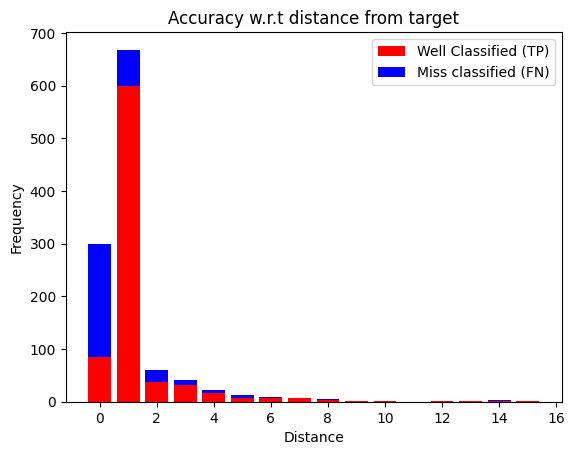

In [ ]:
# importing package
import matplotlib.pyplot as plt

# create data
dist = good_pred_dist

# plot bars in stack manner
plt.bar(dist, good_pred_counts, color='r')
plt.bar(dist, wrong_pred_counts2, bottom=good_pred_counts, color='b')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend(["Well Classified (TP)", "Miss classified (FN)"])
plt.title("Accuracy w.r.t distance from target")
plt.show()

We can see that the model accuracy is different among the different distance from the target. Indeed, we can observe that the model is good to predict the triggers at a distance of 1 from the target value. However, it's less good to detect when the last utterance, i.e. distance of 0, is the triggers for the emotion flip.